In [109]:
import numpy as np

import torch
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from tqdm.notebook import tqdm

import gym
from gym import spaces

from stable_baselines3 import A2C, PPO

import matplotlib.pyplot as plt
import seaborn as sns

# from comet_ml import Experiment

import os
# import ipdb

In [12]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [63]:
class Environment(gym.Env):

    def __init__(self, alpha=1., beta=0.2, tau=0.9, n_item=30, t_max=1000):
        super().__init__()
        
        self.action_space = spaces.Discrete(n_item)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(n_item*2,))
        self.state = torch.zeros((n_item, 2))
        self.n_item = n_item
        self.t_max = t_max
        self.t = 0
        
        self.log_tau = np.log(tau)
        self.alpha = alpha
        self.beta = beta

    def reset(self):
        self.state = torch.zeros((self.n_item, 2))
        self.t = 0
        return self.state.flatten()

    def step(self, action):

        self.state[:, 0] += 1
        self.state[action, 0] = 0
        self.state[action, 1] += 1
        
        done = self.t == self.t_max - 1
        # if done:
        reward = self._reward()
        # else:
        # reward = 0
            
        next_state = self.state.flatten()
        info = {}
        
        self.t += 1
        return next_state, reward, done, info
    
    def _reward(self):
        view = self.state[:, 1] > 0
    
        logp_recall = - self.alpha*self.state[view, 0]*(1-self.beta)**(self.state[view, 1] - 1)
        above_thr = logp_recall > self.log_tau
        return torch.count_nonzero(above_thr).item()

In [64]:
from stable_baselines3.common.callbacks import BaseCallback


class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug
    """
    
    def __init__(self, iterations, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env = None  # type: Union[gym.Env, VecEnv, None]
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = None  # type: Dict[str, Any]
        # self.globals = None  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger = None  # stable_baselines3.common.logger
        # # Sometimes, for event callback, it is useful
        # # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        
        self.pb = None
        self.iterations = iterations

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        
        self.pb = tqdm(total=self.iterations)

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: (bool) If the callback returns False, training is aborted early.
        """
        self.pb.update()
        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

In [117]:
env = Environment(t_max=50, alpha=0.2)
# Define and Train the agent
iterations = env.t_max*1000 
callback = CustomCallback(iterations)
model = PPO('MlpPolicy', env).learn(iterations, n_eval_episodes=1, callback=callback)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [118]:
rewards = []
actions = []

obs = env.reset()
for i in range(10000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    
    rewards.append(reward)
    actions.append(action)
    # env.render()
    if done:
        obs = env.reset()
        break

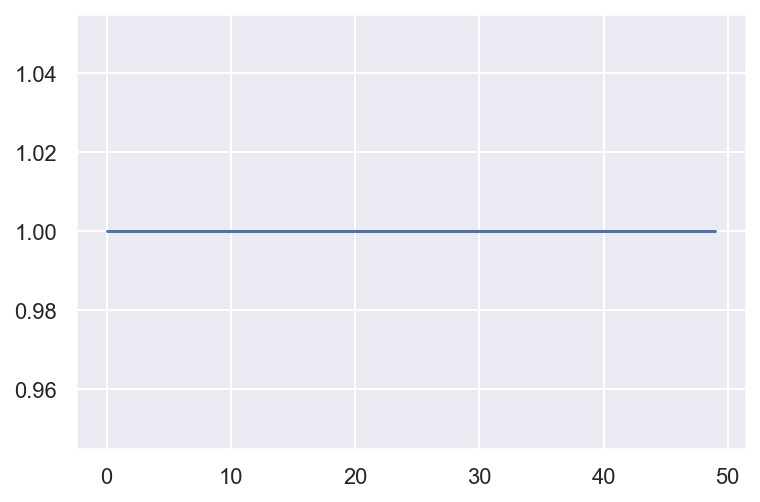

In [119]:
plt.plot(rewards);

In [120]:
len(rewards)

50

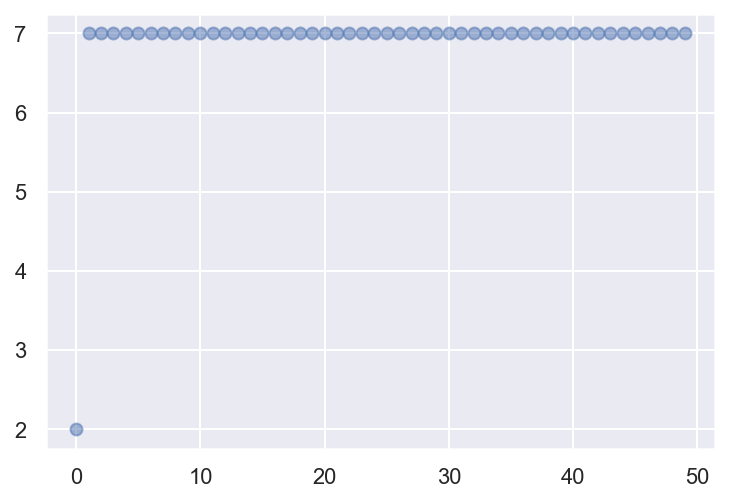

In [121]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

In [88]:
class Threshold:
    def __init__(self):
        pass
    def act(self, env):
        state = env.state
        view = env.state[:, 1] > 0
        logp_recall = - env.state[view, 0]*0.8**(env.state[view, 1] - 1)
        # print("logp", logp_recall)
        under_thr = logp_recall <= env.log_tau
        if torch.count_nonzero(under_thr).item() > 0:
            items = torch.arange(env.n_item)
            viewed = items[view]
            action = viewed[torch.argmin(logp_recall)].item()
        else:
            n_seen = torch.count_nonzero(view).item()
            max_item = env.n_item-1
            action = np.min((n_seen, max_item))

        return action

In [98]:
env = Environment(t_max=50, alpha=0.2)
state = env.reset()
policy = Threshold()
rewards = []
actions = []
while True:
    action = policy.act(env)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

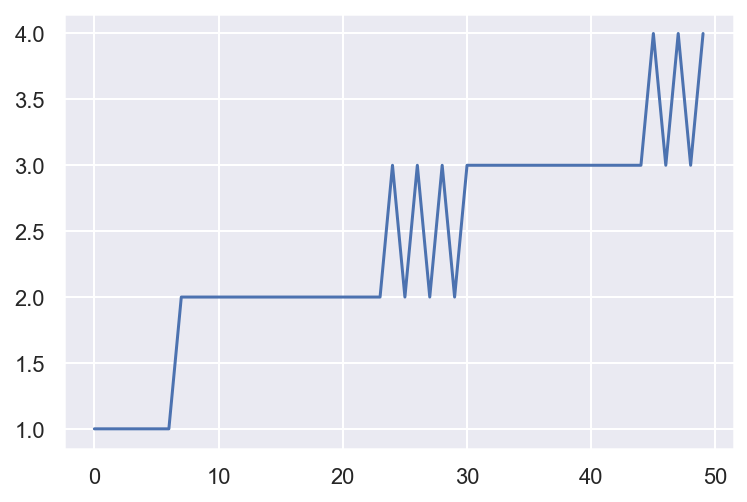

In [99]:
plt.plot(rewards)

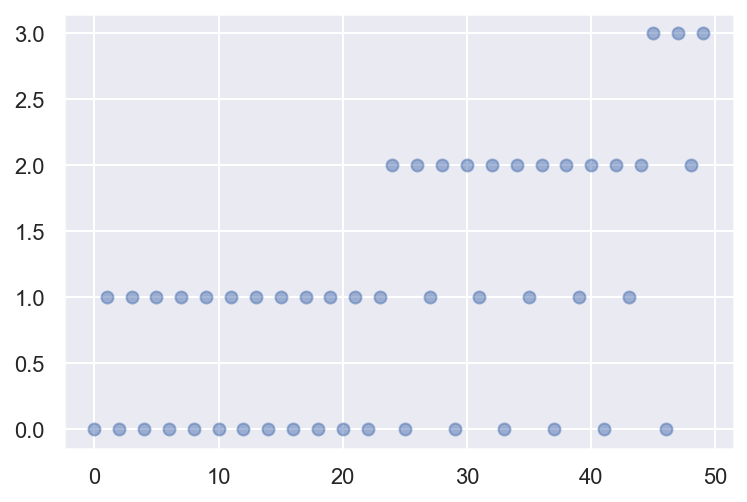

In [100]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5)